In [14]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import LeakyReLU, PReLU, Dropout
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot

In [15]:
cab_df = pd.read_csv("../cab_rides.csv",delimiter='\t',encoding = "utf-16")
weather_df = pd.read_csv("../weather.csv",delimiter='\t',encoding = "utf-16")

cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000, unit='s')
weather_df['date_time'] = pd.to_datetime(weather_df['time_stamp'], unit='s')

#merge the datasets to refelect same time for a location
cab_df['merge_date'] = cab_df.source.astype(str) +" - "+ cab_df.date_time.dt.date.astype("str") +" - "+ cab_df.date_time.dt.hour.astype("str")
weather_df['merge_date'] = weather_df.location.astype(str) +" - "+ weather_df.date_time.dt.date.astype("str") +" - "+ weather_df.date_time.dt.hour.astype("str")

weather_df.index = weather_df['merge_date']

merged_df = cab_df.join(weather_df,on=['merge_date'],rsuffix ='_w')
merged_df['rain'].fillna(0,inplace=True)
merged_df = merged_df[pd.notnull(merged_df['date_time_w'])]
merged_df = merged_df[pd.notnull(merged_df['price'])]
merged_df['day'] = merged_df.date_time.dt.dayofweek
merged_df['hour'] = merged_df.date_time.dt.hour

merged_df.columns
merged_df.count()
X = merged_df[merged_df.product_id=='lyft_line'][['day','distance','hour','temp','clouds', 'pressure','humidity', 'wind', 'rain']]
X.count()
y = merged_df[merged_df.product_id=='lyft_line']['price']
y.count()
X.reset_index(inplace=True)
X = X.drop(columns=['index'])
#X.head()
#features = pd.get_dummies(X)
sc = StandardScaler()
X = sc.fit_transform(X)

In [16]:
# Labels are the values we want to predict
labels = np.array(y)

# Saving feature names for later use
#feature_list = list(features.columns)
# Convert to numpy array
#features = np.array(features)
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, labels, test_size = 0.1, random_state = 0)

In [17]:
input_ = Input(shape = (9,))
x = Dense(32)(input_)
x = Dense(16, activation = 'relu')(x)
x = Dropout(0.25)(x)
x = Dense(8, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(4, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(2, activation = 'relu')(x)
output = Dense(1)(x)

dnn = Model(input_, output)
sgd = optimizers.SGD(lr=0.001, momentum=0.01, clipnorm=1.)
dnn.compile(optimizer=sgd, loss='mean_absolute_error', metrics=['mape'])
history = dnn.fit(train_features, train_labels,
              batch_size=8,
              epochs=30,
           validation_data=(test_features, test_labels))

Instructions for updating:
Use tf.cast instead.
Train on 81936 samples, validate on 9105 samples
Epoch 1/30
81936/81936 [==============================] - 11s 136us/step - loss: 2.3100 - mean_absolute_percentage_error: 39.2310 - val_loss: 1.1277 - val_mean_absolute_percentage_error: 19.9556
Epoch 2/30
81936/81936 [==============================] - 11s 134us/step - loss: 1.3323 - mean_absolute_percentage_error: 23.8510 - val_loss: 1.0621 - val_mean_absolute_percentage_error: 19.3533
Epoch 3/30
81936/81936 [==============================] - 12s 142us/step - loss: 1.1616 - mean_absolute_percentage_error: 21.5724 - val_loss: 1.0497 - val_mean_absolute_percentage_error: 19.0227
Epoch 4/30
81936/81936 [==============================] - 11s 135us/step - loss: 1.0855 - mean_absolute_percentage_error: 20.3838 - val_loss: 1.0595 - val_mean_absolute_percentage_error: 18.6778
Epoch 5/30
81936/81936 [==============================] - 11s 136us/step - loss: 1.0547 - mean_absolute_percentage_error: 1

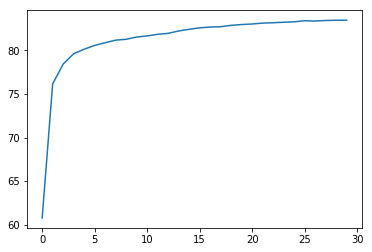

In [20]:
pyplot.plot(np.full((30,), 100)-history.history['mean_absolute_percentage_error'])
pyplot.show()

In [21]:
predict_test = dnn.predict(test_features)
errors = abs(predict_test - test_labels)
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 62.09 %.


In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
predict_test = dnn.predict(test_features)
acc = mean_absolute_percentage_error(predict_test, test_labels)
print('Accuracy:', round(100-acc, 2), '%.')

Accuracy: 59.22 %.


In [24]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)

In [25]:
clf.fit(train_features, train_labels)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
predictions = clf.predict(test_features)

In [27]:
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 1.0 degrees.


In [28]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 79.69 %.
